## Star Wars Analysis

Our website is at: https://fabianscott.github.io/

---

#### Datasets

We initially started with only one dataset this being the Characters dataset. We created this dataset ourselves by making both requests to an API and by making request to the star wars databank website. This process is explained in more detail futher down this notebook.

We chose this dataset as we wanted to get information on each character and try to group them together based on different features/traits. We thought this could give us an idea of how well some groups actually represent the best way of grouping the characters together with the Louvain Algorithm. What are the most dominant groups? Are the characters mainly connected by social, political or other types of relationsships?

Together with this we would want to analyze the words that each group use. What are the words from each group dominated by? Are there a significant different in the words used in different groups?

We also wanted to analyze the movie scripts for further word analysis. We went on to find a few different datasets with the biggest one being one from kaggle with movies script for move 4,5 & 6. We first made some preprocessing and then analysis on this. We wanted to find out which characters where the most dominant in each movie. Would that match our expectation? Could we predict the story of the movie by using TF-IDF? What where the most used words by each main character? What are their semantics?

Those are some of the question we would like to answer in this project.

---
### Goal

Our goal was to give the user an introduction to the Star Wars Universe and explain the social structures within. We also wanted to give some more in-depth knowledge on the main characters in the selected movies, what words they use, if they are mainly in a negative or positive context and how present they are.

Hopefully this would aid anyone being interested in the Star Wars Universe and their understanding of the connections within.

---

## Star Wars Analysis

Our website is at: https://fabianscott.github.io/

---

#### Datasets

We initially started with only one dataset this being the Characters dataset. We created this dataset ourselves by making both requests to an API and by making request to the star wars databank website. This process is explained in more detail futher down this notebook.

We chose this dataset as we wanted to get information on each character and try to group them together based on different features/traits. We thought this could give us an idea of how well some groups actually represent the best way of grouping the characters together with the Louvain Algorithm. What are the most dominant groups? Are the characters mainly connected by social, political or other types of relationsships?

Together with this we would want to analyze the words that each group use. What are the words from each group dominated by? Are there a significant different in the words used in different groups?

We also wanted to analyze the movie scripts for further word analysis. We went on to find a few different datasets with the biggest one being one from kaggle with movies script for move 4,5 & 6. We first made some preprocessing and then analysis on this. We wanted to find out which characters where the most dominant in each movie. Would that match our expectation? Could we predict the story of the movie by using TF-IDF? What where the most used words by each main character? What are their semantics?

Those are some of the question we would like to answer in this project.

---
### Goal

Our goal was to give the user an introduction to the Star Wars Universe and explain the social structures within. We also wanted to give some more in-depth knowledge on the main characters in the selected movies, what words they use, if they are mainly in a negative or positive context and how present they are.

Hopefully this would aid anyone being interested in the Star Wars Universe and their understanding of the connections within.

---

---

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from tqdm import tqdm
from ast import literal_eval

# Initial data collecting

To get data from all the starwars characters from the official Starwars Databank, we first need to know all the possible URLs to get the data from. This is done by getting the list of all the characters from the 'starwars-databank-server.vercel.app' API, which is then appended to the base URL:

In [ ]:
URL_CHARACTERS = "https://starwars-databank-server.vercel.app/api/v1/characters"

def getResponse(url):
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"Failed to get data. Status code: {response.status_code}")
    data = response.json()
    return data

def cleanString(var):
    return str(var).replace("\"", "\'")

def getNextUrl(data):
    BASE_URL = "https://starwars-databank-server.vercel.app/"
    try: return (BASE_URL + data["info"]["next"])
    except: return None

In [ ]:
character_df_old = None
temp_url = URL_CHARACTERS
character_name_list = []

for _ in tqdm(range(100)):
    data = getResponse(temp_url)
    character_name_list += [cleanString(character["name"]) for character in data["data"]]
    
    # Since the getResponse function doesn't return all characters
    # we need to loop through the different API "pages" with getNextUrl
    temp_url = getNextUrl(data)
    if temp_url is None:
        print("Done!")
        break

url_name_list = ["-".join(name.lower().replace("\'", "").split()) for name in character_name_list]

 96%|█████████▌| 96/100 [00:54<00:02,  1.75it/s]

Done!


Now that we have a list of character names we can then start getting the character data we actually want from the official Star Wars databank website. So we start appending and checking the different URLs, from the resulting HTML pages we can then extract the desired data:

In [ ]:
BASE_URL = "https://www.starwars.com/databank/"
URL_ADDITIONS = url_name_list

errors = []
number_of_errors = 0

def add_one_error():
    global number_of_errors
    number_of_errors += 1

def get_page(url):
    try: response = requests.get(url)
    except: errors.append(url); add_one_error(); return None
    return BeautifulSoup(response.text, "html.parser")

def check_if_error_404(soup):
    try: soup.find_all("p", class_="desc")[0].text; return False
    except: return True

def get_properties(soup):
    stats = soup.find_all("section", class_="module stats span-full-screen content-span-full-screen secondary-theme dark")
    categories = stats[0].find_all("div", class_="category")
    properties = {}
    for category in categories:
        heading = category.find_all("div", class_="heading")[0].text
        property_names = [p.text for p in category.find_all("div", class_="property-name")]
        properties[heading] = property_names
    return properties

def get_description(soup):
    discription = soup.find_all("p", class_="desc")[0].text
    discription = discription.replace("\n", "")
    return discription

def get_history(soup):
    all_referals = []
    all_text = soup.find_all("div", class_="rich-text-output")
    if len(all_text) == 0:
        return None, None
    minor_text_samples = all_text[0].find_all("p")
    all_history_text = ""
    for sample in minor_text_samples:
        referals = sample.find_all("a")
        for referal in referals:
            all_referals.append(referal.text.strip())
        all_history_text += " " + sample.text
    return all_history_text, all_referals

def get_descriptions(url):
    soup = get_page(url)
    if soup is None or check_if_error_404(soup):
        errors.append(url)
        add_one_error()
        return None
    description = get_description(soup)
    history, referal = get_history(soup)
    properties = get_properties(soup)
    return description, referal, properties, history

#### Getting all the correct URL's before proceeding

We noticed that some of the automade URL's did not work properly. We then saved these to an error.csv file:

In [ ]:
def check_if_working_url(url):
    soup = get_page(url)
    return not (soup is None or check_if_error_404(soup))

In [ ]:
all_urls = []
errors = []

for i in tqdm(range(len(character_name_list))):
    name = character_name_list[i]
    url_addition = URL_ADDITIONS[i]
    full_url = BASE_URL + url_addition
    if check_if_working_url(full_url):
        all_urls.append((name, full_url))
    else:
        errors.append((name, full_url))

100%|██████████| 964/964 [11:32<00:00,  1.39it/s]


### Concat cleaned errors and all_urls

The error.csv was only 43 lines long, so we decided to manully search for the person on the star-wars databank, and then copy the correct html back into the error.csv, as we found this to be most efficient and accurate way of correcting the mistakes:

In [ ]:
potentially_cleaned_urls = []

cleaned_errors = [lst.split("\n") for lst in open("cleaned_errors.csv", "r").readlines()]
for cleaned_error in cleaned_errors:
    potentially_cleaned_urls.append(cleaned_error[0])

In [ ]:
errors = []

for i in tqdm(range(len( potentially_cleaned_urls))):
    name = literal_eval(potentially_cleaned_urls[i])[0]
    full_url = literal_eval(potentially_cleaned_urls[i])[1]
    if check_if_working_url(full_url):
        all_urls.append((name, full_url))
    else:
        errors.append((name, full_url))

100%|██████████| 68/68 [00:41<00:00,  1.63it/s]


In [ ]:
with open("errors.csv", "w") as f:
    for line in errors:
        f.write(str(line) + "\n")

We then had an errors.csv with no lines left, which is exactly what we wanted.

### Making the dataframe

In [ ]:
# creating dataframe objects:
new_names = []
errors = []
descriptions = []
referrals = []
properties = []
histories = []
number_of_errors = 0

for i in tqdm(range(len(all_urls))):
    name = all_urls[i][0]
    full_url = all_urls[i][1]
    descriptions_tuple = get_descriptions(full_url)

    if descriptions_tuple is None:
        continue 
    
    description, referral, property, history = descriptions_tuple
    new_names.append(name)
    descriptions.append(description)
    referrals.append(referral)
    properties.append(property)
    histories.append(history)

    all_urls.append((name, full_url))  

print("Number of errors: ", number_of_errors)
print(*errors, sep="\n") 

cleaned_descriptions = [description.replace("\n", "").replace("\r", "") for description in descriptions]
df = pd.DataFrame({"name": new_names, "description": cleaned_descriptions, "referrals": referrals, "properties": properties, "history": history})
df.to_csv("descriptions.csv", sep=";")

100%|██████████| 958/958 [10:44<00:00,  1.49it/s]

Number of errors:  0



In [ ]:
print("Number of errors: ", number_of_errors)
with open("errors.csv", "w") as f:
    for line in errors:
        f.write(line + "\n")

Number of errors:  0


We now have a dataset with a lot of information about each character:

In [6]:
import pandas as pd
df = pd.read_csv("descriptions.csv", sep=";")
df

,Unnamed: 0,name,description,referrals,properties,history
0,0,'Hyper' Rod,"In his specially-modified Seven Deuce Blaster,...",NaN,{'Appearances': ['Star Wars: The Bad Batch']},NaN
1,1,'Quick-Draw' Quasar,"An amalgamation of droid parts, riot racer ""Qu...",NaN,{'Appearances': ['Star Wars: The Bad Batch']},NaN
2,2,'Steel Claw' Kane,"At the Safa Toma riot races, ""Steel Claw"" Kane...",NaN,"{'Appearances': ['Star Wars: The Bad Batch'], ...",NaN
3,3,'The Trickster' Flash Raktor,Perhaps riot racer Flash Raktor gets his nickn...,NaN,"{'Appearances': ['Star Wars: The Bad Batch'], ...",NaN
4,4,2BR-NTB,"Loyal to Norath Kev, the droid 2BR-NTB has a d...",NaN,{'Appearances': ['Star Wars Resistance']},NaN
...,...,...,...,...,...,...
953,953,Venisa Doza,"A fearless freedom fighter, Venisa Doza once f...","['the Resistance', 'Colossus', 'Jade Squadron']","{'Appearances': ['Star Wars Resistance'], 'Gen...",NaN
954,954,Wicket W. Warrick,Wicket W. Warrick was the brave young Ewok who...,"['Empire', 'Endor', 'Ewok', 'Bright Tree Villa...",{'Appearances': ['Star Wars: Return of the Jed...,NaN
955,955,Willie (W1-LE),W1-LE was Lando Calrissian’s personal attendan...,NaN,"{'Appearances': ['Star Wars Rebels'], 'droid':...",NaN
956,956,Xi'an,"An athletic and agile Twi'lek, Xi'an is the bl...",NaN,"{'Appearances': ['The Mandalorian'], 'Gender':...",NaN


---

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

# Getting tokens

To tokenize the descriptions we'll need a function that tokenizes a string and removes undesired words and characters. We'll use the NLTK library for this.

In [2]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from string import punctuation

stopwords = stopwords.words('english')
punctuation = list(punctuation)
ps = PorterStemmer()


# Convert a piece of text into tokens
# With stemming, punctuation removal, stopword removal, and digit removal etc.
def get_tokens(text):
    tokens_raw_lower = word_tokenize(text.lower())
    try:
        tokens = []
        for token in tokens_raw_lower:
            if token.isdigit(): # Remove digits
                continue
            elif token in punctuation or token in ["'s","’",".","--"] or token in stopwords: # Remove punctuation and stopwords
                continue
            
            token = ps.stem(token)
            tokens.append(token)
        return tokens
    except: return []

With this get_tokens function it's now possible to get the tokens, but unfortunately the returned words are stemmed which doesn't look nice and is only relevant for getting the TF-IDF of unique words. And since we still want to be able to display some beautiful Wordclouds with actual words that match (as best as possible) the original words we therefore choose the most frequent and therefore most likely original version of the stemmed word, and replace it with that.

In [3]:
import pandas as pd
from ast import literal_eval

from collections import defaultdict, Counter
from statistics import mode


# Loading the descriptions dataset:
character_data = pd.read_csv('ProjectA/descriptions.csv', sep=";", usecols=[1, 2, 3, 4, 5], converters={4: literal_eval})
character_data.set_index("name", inplace=True)
character_data = character_data.sort_index()

# Tokenizing the entire corpus:
star_wars_vocab = word_tokenize(" ".join(character_data["description"]).lower())
# Making the dictionary of connections between stemmed words and the "original" words:
star_wars_vocab_dict = defaultdict(list)
for v in star_wars_vocab:
    star_wars_vocab_dict[ps.stem(v)].append(v)
# The function to "recreate" the tokens:
token_beautifier = lambda token: mode(sorted(star_wars_vocab_dict[token])) # The "beautified" token function.

# Adding the tokens column to the dataset:
character_data["tokens"] = character_data["description"].apply(get_tokens).apply(lambda tokens: list(map(token_beautifier, tokens)))
character_data = character_data[["description", "tokens", "properties", "referrals", "history"]]

# Optionally saving the dataset:
# character_data.to_csv("ProjectA/descriptions_tokens.csv", sep=";")

# Getting character groups

To get the different desired groupings we create a defaultdict and iterate over the properties of each character, but now we're presented by two options, either we group the different characters strictly by arbitrarily choosing the first of many possiple items in a list of properties, this means that there are no overlaps in the groupings, but it also negatively affects the wordclouds for groups that get missed because of this "strictness", so instead we choose to "loosely" group these characters such that they can be in multiple groups, this means that there are overlaps in the groupings, but it also means that the wordclouds are more complete.

In [4]:
def get_groups(property_choice, group_method="loose", character_data=character_data):
    errors = 0
    groups_dict = defaultdict(list)
    for i in range(len(character_data)):
        character = character_data.iloc[i]
        character_prop = character["properties"]
        try:
            if group_method == "strict": # The strict grouping method, where each character can only be in one group.
                prop = character_prop[property_choice][0]
                groups_dict[prop].append(i)
            elif group_method == "loose": # The loose grouping method, where each character can be in multiple groups.
                props = character_prop[property_choice]
                for prop in props: groups_dict[prop].append(i)
        except:
            errors += 1
            continue

    error_text = f'This many characters {errors}, do not have the property: {property_choice}.'
    
    # Creating a dictionary of the groups_dict, where the keys are the group names, and the values are the characters in the group.
    character_groups = defaultdict(None)
    for group_name, group_chars in list(groups_dict.items()):
        character_groups[group_name] = character_data.iloc[group_chars]
    character_groups_sorted = dict(sorted(character_groups.items(), key=lambda item: len(item[1]), reverse=True))
    return character_groups_sorted, error_text

# Calculating TF-IDF

To create the TF-IDF word-frequency-dictionary for each group we first calculate the IDF of the whole corpus. Then we iterate over each group and each word in that group, adding the calculated TF-IDF for each word to the "word-frequency-dictionary".

In [5]:
import numpy as np

# TF and IDF formulas:
IDF = lambda term_count: np.log10(len(character_data) / term_count)
TF = lambda term_count, N: (term_count / N) * 100

# Finding the IDF for the whole corpus:
corpus_total_tokens = sum(character_data["tokens"].apply(set).apply(list), [])
corpus_total_tokens_count = Counter(corpus_total_tokens)
IDF_dict = {word: IDF(count) for word, count in corpus_total_tokens_count.items()}

# Function to calculate the word-frequency-dictionaries for each group in a list of communities:
def get_TF_IDF(communities, single=False):
    if single: communities = [communities]
    
    community_TF_IDF = []
    for group in communities:
        group_total_tokens = sum(group["tokens"], []) # Adding all tokens of the group together.
        group_total_tokens_count = Counter(group_total_tokens)
        
        # Calculating the TF-IDF and making it into a dictionary:
        tf_idf = {word: TF(count, len(group_total_tokens)) * IDF_dict[word] for word, count in group_total_tokens_count.items()}
        community_TF_IDF.append(dict(sorted(tf_idf.items(), key=lambda item: item[1], reverse=True)))
    
    if single: return community_TF_IDF[0]
    return community_TF_IDF

# An extra function to combine the dictionaries of multiple communities into one
# for example with the purpose of making a wordcloud of all the groups:
def combine_dictionaries(dictionaries):
    combined_dict = {}
    counts = {}
    
    for dictionary in dictionaries:
        for key, value in dictionary.items():
            if key not in combined_dict:
                combined_dict[key] = value
                counts[key] = 1
            else:
                combined_dict[key] += value
                counts[key] += 1
    for key in combined_dict:
        combined_dict[key] /= counts[key]
    
    return dict(sorted(combined_dict.items(), key=lambda item: item[1], reverse=True))

# Making wordclouds

To create the wordclouds we use the wordcloud library where we've chosen to include a Star Wars font and a relevant background image-mask of the Death Star. Furthermore we've chosen to color the words according to their TF-IDF score, and to make the wordclouds more readable we've chosen not to include words that are too small (in terms of font-size which is of course affected by TF-IDF).

In [6]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from PIL import Image

def create_wordcloud(word_frequency_dict, title_string=None, bottom_string=None, save_path=None):
    # The background mask for the wordcloud:
    sw_mask = np.array(Image.open("ProjectA/images_wordclouds/death_star1.png").convert('RGB'))
    
    # The color function to decide how words are colored:
    def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return f"hsl(0, 0%, {font_size * 0.7 + 30}%)"

    # The wordcloud itself, with the mask, color function, and other parameters included:
    # Where the word_frequency_dict is the dictionary we find with the get_TF_IDF and get_groups functions.
    wordcloud = WordCloud(
        font_path="ProjectA/images_wordclouds/StarJedi.ttf", background_color="black",
        width=600, height=600, max_words=400, min_font_size=9, max_font_size=100,
        mask=sw_mask).generate_from_frequencies(word_frequency_dict)
    wordcloud = wordcloud.recolor(color_func=grey_color_func, random_state=3)

    from matplotlib.font_manager import FontProperties
    custom_font = FontProperties(fname="ProjectA/images_wordclouds/StarJedi.ttf", size=25)
    
    # Finally plotting the wordcloud:
    # We chose to plot the wordclouds with some additional exploratory information, such as the title and bottom string.
    # Where the title string is the name of the group, and the bottom string contains informations about what the wordcloud is based on.
    plt.figure( figsize=(20,10), facecolor='k' );
    plt.imshow(wordcloud, interpolation='bilinear');
    plt.title(f"{title_string}\nwordcloud", color="white", fontproperties=custom_font);
    plt.axis("off");
    plt.figtext(0.5, 0.05, bottom_string, ha="center", fontsize=15, color="white")
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

Now that we have all the different functions we need to creat the groups, find the TF-IDF frequency dicts for them and create the wordclouds, we can finally compile it all together into this function we call get_group_wordclouds.

In [7]:
def get_group_wordcloud(group_idx, property_choice, group_method="loose", save_wordcloud=False):
    # First we get the groups and save the error text:
    character_groups, error_text = get_groups(property_choice, group_method=group_method)
    
    # We save the name and lenght of the group, and the error/info text:
    group_name = list(character_groups.keys())[group_idx]
    group_len = len(character_groups[group_name])
    info_text = f"This many characters {group_len}, have the property: {group_name}"
    
    # We get the TF-IDF word frequency dictionary for the group:
    group_word_frequencies = get_TF_IDF(character_groups[group_name], single=True)
    
    # We create the wordcloud and give it a savepath to save the plots generated:
    filename_convert = lambda s: "".join(x for x in s if x.isalnum()) # This fixes filenames with special characters.
    save_path = f"ProjectA/images_wordclouds/Wordcloud_{property_choice}_{filename_convert(group_name)}.png" if save_wordcloud else None
    create_wordcloud(group_word_frequencies, title_string=group_name.lower(), bottom_string=f"{error_text}\n{info_text}", save_path=save_path)

# Saving interesting wordclouds:

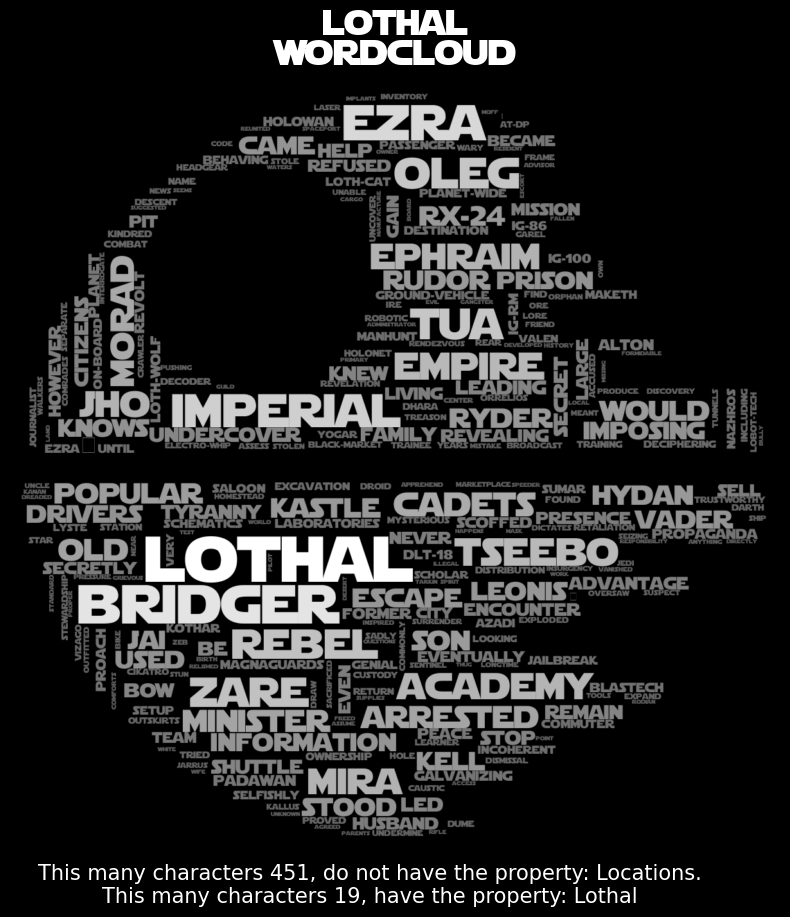

In [15]:
# ['Appearances', 'Locations', 'Affiliations', 'Gender', 'species']
# Those ^ are the different properties we've find to be interesting to look at.
# And below is an example of how to use the get_group_wordcloud function:

# The movies that were interesting:
# "Star Wars: The Clone Wars"
# "Star Wars: A New Hope (Episode IV)"
# "Star Wars: Return of the Jedi (Episode VI)"
# "Star Wars: The Empire Strikes Back (Episode V)"
# "Star Wars: The Force Awakens (Episode VII)"
# [0, 14, 9, 15, 4]

from tqdm import tqdm
for i in tqdm([0, 14, 9, 15, 4]):
    get_group_wordcloud(i, "Appearances", group_method="loose", save_wordcloud=True)

In [1]:
import os
import re
import ast
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import netwulf as nw
import networkx as nx
from scipy import stats as st
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx.algorithms.community as nx_comm

In the following we find the links present in our graph. Firstly by searching through the character descriptions for any occurence of any other character's name and next we use hyperlinks referring to other characters. We did plan on searching for nicknames in the text, but found it was too hard to find a generalisable method for finding and using nicknames. The main problem is characters with the same second name, as any reference to Skywalker would then link to all the Skywalkers. By doing it the way we have, we get more 'formal' or strong links.

In [4]:
# Load the the data
df_texts = pd.read_csv('descriptions.csv', sep=';')
texts = df_texts['description'].values
names = df_texts['name'].values
hyper_refs = df_texts['referrals']
properties_list = []
for prop in df_texts['properties']:
    properties_list.append(ast.literal_eval(prop))

In [4]:
# Search through each character description for every other character's name
adjacency_matrix = np.zeros((len(names), len(names)))
names_all = {name: [name] for name in names}
# Assuming a clean text with only lower case words, no punctuation
for i, text in tqdm(enumerate(texts)):
    # word_array = np.array(text.split(' '))
    counts = []
    for real_name in names:
        count = 0
        for nick_name in names_all[real_name]:
            findall = re.findall(nick_name, text)
            text = re.sub(nick_name, '', text)
            count += len(findall)
        counts.append(count)

958it [00:36, 25.99it/s]


In [5]:
# Do as above but search for hyperlinks instead
adjacency_matrix_compare = np.zeros((len(names), len(names)))
names_all = {name: [name] for name in names}
# Assuming a clean text with only lower case words, no punctuation
for i, text in tqdm(enumerate(hyper_refs)):
    # word_array = np.array(text.split(' '))
    counts = []
    for real_name in names:
        count = 0
        for nick_name in names_all[real_name]:
            count += len(re.findall(nick_name, str(text)))
        counts.append(count)
    # counts = np.array(counts)
    # The row is the node from which the edge comes and the column is thus the receiving node
    adjacency_matrix_compare[i] += np.array(counts)

958it [00:36, 26.10it/s]


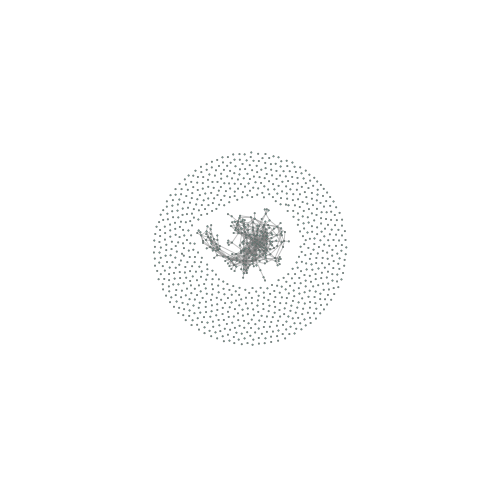

In [6]:
# Save and inspect the graph
adjacency_matrix += (adjacency_matrix_compare == 1) * (adjacency_matrix == 0)
G = nx.from_numpy_matrix(adjacency_matrix)
network, config = nw.visualize(G, config={'zoom':0.6, 'node charge':-15, 'node gravity': 0.7})
nw.save("Graph.json", network, config, G)

In [11]:
len(G.nodes)

958

In [14]:
# Load the graph, so it doesn't have to be created every time
stylized_network, config, G = nw.load("Graph.json")

This next part shows the degree distribution of the graph.

Maximum degree: 68, Minimum degree: 0
Assortivity coefficient r = 0.007


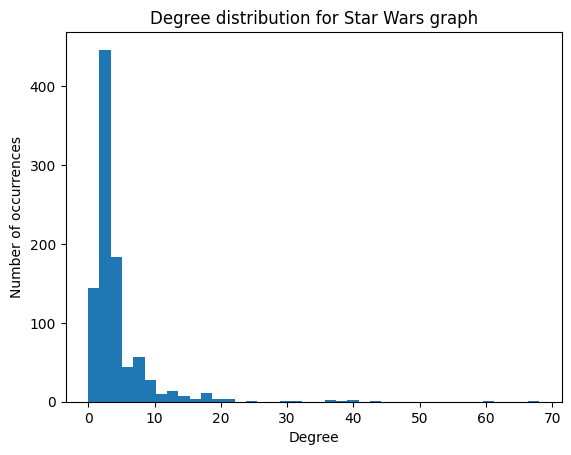

In [29]:
import matplotlib.pyplot as plt
degrees = [d for _, d in G.degree()]
print(f'Maximum degree: {max(degrees)}, Minimum degree: {min(degrees)}')
r = nx.degree_assortativity_coefficient(G)
print(f"Assortivity coefficient r = {r:.3f}")
plt.hist(degrees, bins=40)
plt.title('Degree distribution for Star Wars graph')
plt.ylabel('Number of occurrences')
plt.xlabel('Degree')
plt.savefig('DegreeDistribution.png')
plt.show()

The degree distribution is very skewed by the presence of lots of nodes without any links. We also observe a couple node with a very high number of links.

In [21]:
# Compute the average connected component
connected_largest = sorted(nx.algorithms.connected_components(G), key=len, reverse=True)[0]
G_sub = nx.Graph.subgraph(G, connected_largest)
avg_shortest_sub = nx.average_shortest_path_length(G_sub)
print(f'Average shortest path in the largest connected component is {round(avg_shortest_sub, 2)}')

Average shortest path in the largest connected component is 4.63


In [1]:
import os
import ast
import re
from ast import literal_eval
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import netwulf as nw
import networkx as nx
from scipy import stats as st
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx.algorithms.community as nx_comm
import colorsys
import random

In [2]:
# Load the network
df_texts = pd.read_csv('descriptions.csv', sep=';', converters={'properties': literal_eval})
stylized_network, config, G = nw.load("Graph.json")

In [3]:
# Create a dictionary and list in the format used by the functions
def return_set():
    return set()
def return_list():
    return []
properties_dict = defaultdict(return_set)
for dic in df_texts['properties']:
    for el in dic.keys():
        for el1 in dic[el]:
            properties_dict[el].add(el1)
properties_list = []
for prop in df_texts['properties']:
    properties_list.append(prop)

In [4]:
def generate_colors(n):
    # Set the number of color hues to evenly space the colors
    hue_values = [i/n for i in range(n)]
    saturation = 0.5
    value = 0.95

    # Convert the HSV color values to RGB format and store them in a list
    colors = []
    for hue in hue_values:
        r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
        r, g, b = int(r * 255), int(g * 255), int(b * 255)
        colors.append((r, g, b))

    # Shuffle the list to randomize the order of colors
    random.shuffle(colors)

    return colors

def graph_with_grouping(properties_dict, attribute, properties_list, Graph, return_communities=False, return_dict=False):
    """
    Given the dictionay of properties and the property/attribute
    of interest, along with the list of properties ordered by
    node, return the graph with randomised colors.
    If return_communities, it will return a list of lists of
    communities
    :param properties_dict:
    :param attribute:
    :param Graph:
    :return:
    """
    from copy import deepcopy

    Graph = deepcopy(Graph)
    possible_values = properties_dict[attribute]
    colors_avail = generate_colors(len(possible_values))
    color_dict = {key: value for key, value in zip(possible_values, colors_avail)}
    color_dict['None'] = (150, 150, 150)
    color_list = []
    communities = defaultdict(return_list)

    for props, node in zip(properties_list, Graph.nodes):
        # Use the size to set the colour
        
        if attribute in props.keys():
            communities[props[attribute][0]].append(node)
            color = '#%02x%02x%02x' % color_dict[props[attribute][0]]
        else:
#             communities[None].append(node)
            color = '#%02x%02x%02x' % (150, 150, 150)
        color_list.append(color)
        
    # zip it up into a dictionary and set it as node attribute
    dictionaryColor = dict(zip(list(Graph.nodes), color_list))
    nx.set_node_attributes(Graph, dictionaryColor, 'group')
    communities = [val for val in communities.values()]
    if return_dict:
        return Graph, communities, color_dict
    if return_communities:
        return Graph, communities
    return Graph

def graph_with_louvain(Graph, communities, return_dict=False):
    """
    Given the dictionay of properties and the property/attribute
    of interest, along with the list of properties ordered by
    node, return the graph with randomised colors.
    If return_communities, it will return a list of lists of
    communities
    :param properties_dict:
    :param attribute:
    :param Graph:
    :return:
    """
    from copy import deepcopy

    Graph = deepcopy(Graph)
    # possible_values = properties_dict[attribute]
    colors_avail = generate_colors(len(communities))
    color_dict = {}

    for com_set, color in zip(communities, colors_avail):
        for val in com_set:
            color_dict[val] = color

    color_list = []
    for node in Graph.nodes:
        # Use the size to set the colour
        color = '#%02x%02x%02x' % color_dict[node]
        color_list.append(color)

    # zip it up into a dictionary and set it as node attribute
    dictionaryColor = dict(zip(list(Graph.nodes), color_list))
    nx.set_node_attributes(Graph, dictionaryColor, 'group')

    if return_dict:
        return Graph, color_dict
    return Graph

def modularity(G, communities):
    m = G.number_of_edges()
    q = .0
    for c in communities:
        lc = G.subgraph(c).number_of_edges()
        kc = sum(G.degree(n) for n in c)
        q += lc / m - (kc / (2 * m)) ** 2
    return q

The following section creates the clusterings based on each attribute and visualises them using netwulf. We create the legends seperately because some of them are massive

In [ ]:
import matplotlib.patches as mpatches

color_dicts, modularities = [], []
for attribute in properties_dict.keys():
    # Creates the graph with attributes and corresponding colours
    G1, communities, color_dict = graph_with_grouping(properties_dict, attribute, properties_list, G, return_dict=True)
    network, config = nw.visualize(G1, config={'zoom':0.73, 'node charge':-15, 'node gravity': 0.7, 'post to python': True})
    nx.draw(G1)
    plt.tight_layout()
    plt.savefig(f"Graph_{attribute}.png")
    # nw.save(f"Graph_{attribute}.json", network, config, G1)

    legendFig = plt.figure("Legend plot")
    handles = [mpatches.Patch(color=np.array(val)/255, label=key) for key, val in color_dict.items()]
    # plt.legend(handles=handles)
    legendFig.legend(handles=handles)
    legendFig.set_figheight(10)
    legendFig.savefig(f'legend_{attribute}.png')
    modul = modularity(G1, communities)
    print(f"{attribute} has modularity: {modul}")
    # print(color_dict)
    modularities.append(modul)
    color_dicts.append(color_dict)
    plt.clf()

C:\Users\toell\AppData\Local\Temp\ipykernel_35500\1947316304.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Appearances has modularity: 0.3005900808653643
species has modularity: 0.05355279221802146
droid has modularity: 0.0007572923230413778
Dimensions has modularity: 0.00238099926486032
Weapons has modularity: 0.034859240443184225
Locations has modularity: 0.08993810386473433
Affiliations has modularity: 0.10825834252257929
Gender has modularity: -0.0011822949485401774
Vehicles has modularity: 0.020455917874396136
Creature has modularity: -1.0666089056920815e-05
generic has modularity: -3.2818735559756356e-06
star wars has modularity: -5.5791850451585804e-05
Tool has modularity: -0.0018362082545683679


When looking at the modularities of the different clusterings, the only one above 0.25 is appearances. This is unsurprising as the appearances are a solid explanation for a link. If the two characters appear in the same material there is a high likelihood that they have something to do with each other.

In [ ]:
modularities

In [ ]:
partition = nx_comm.louvain_communities(G)
G1 = graph_with_louvain(G, partition)
network, config = nw.visualize(G1, config={'zoom':0.73, 'node charge':-15, 'node gravity': 0.7, 'post to python': True})
nx.draw(G1)
plt.savefig(f"Graph_louvain.png")
print(f'Louvain groups have modularity {modularity(G1, partition)}')

Text for the section:


---

## Movie Scripts

----

This is a script to work with the movie scripts. We found 3 of them online, which we will start to do some preprocessing on:

In [30]:
import pandas as pd
import os

ep4 = pd.read_csv('SW_EpisodeIV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep5 = pd.read_csv('SW_EpisodeV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep6 = pd.read_csv('SW_EpisodeVI.txt', delimiter='\t', header=None, names=['character/dialogue'])
episodes = [ep4, ep5, ep6]

In [31]:
ep4

,character/dialogue
0,"character ""dialogue"""
1,"1 ""THREEPIO"" ""Did you hear that? They've shut..."
2,"2 ""THREEPIO"" ""We're doomed!"""
3,"3 ""THREEPIO"" ""There'll be no escape for the Pr..."
4,"4 ""THREEPIO"" ""What's that?"""
...,...
1006,"1006 ""LUKE"" ""Oh, no!"""
1007,"1007 ""THREEPIO"" ""Oh, my! Artoo! Can you hear..."
1008,"1008 ""TECHNICIAN"" ""We'll get to work on him ri..."
1009,"1009 ""THREEPIO"" ""You must repair him! Sir, if..."


In [32]:
def convertToProperDf(df):
    texts = df["character/dialogue"][1:]
    characters = []
    dialogues = []
    for text in texts:
        tup = [t.strip('"') for t in text.split('"') if t.strip()]
        new_tup = (tup[0], tup[1], " ".join(tup[2:]))
        number, character, dialogue = new_tup
        characters.append(character)
        dialogues.append(dialogue)
    new_df = pd.DataFrame({'character': characters, 'dialogue': dialogues})
    return new_df

cleaned_episodes = [convertToProperDf(episode) for episode in episodes]
cleaned_episodes[0]

,character,dialogue
0,THREEPIO,Did you hear that? They've shut down the main...
1,THREEPIO,We're doomed!
2,THREEPIO,There'll be no escape for the Princess this time.
3,THREEPIO,What's that?
4,THREEPIO,I should have known better than to trust the l...
...,...,...
1005,LUKE,"Oh, no!"
1006,THREEPIO,"Oh, my! Artoo! Can you hear me? Say somethi..."
1007,TECHNICIAN,We'll get to work on him right away.
1008,THREEPIO,"You must repair him! Sir, if any of my circui..."


In [33]:
cleaned_episodes[0].to_csv('SW_EpisodeIV.csv', sep=";", index=False)
cleaned_episodes[1].to_csv('SW_EpisodeV.csv', sep=";", index=False)
cleaned_episodes[2].to_csv('SW_EpisodeVI.csv', sep=";", index=False)

In [34]:
sum([len(ep) for ep in cleaned_episodes])

2523

We now have the cleaned datasets with the character speaking and the corresponding dialogue. We have 2523 dialogues

---

We will now start making graph based on the movie scripts. We will start by defining some helper functions to help us get some information about each episode:
- nodes
- links
- nodes with most links

In [35]:
def findNodes(name, df):
    nunique = df.character.unique().tolist()
    print(f"Number of unique characters for {name}: ", len(nunique))
    return nunique

def findLinks(name, df):
    links = []
    dialogues = df.character.tolist()
    for i in range(2, len(dialogues)-1):
        characters = list(set(dialogues[i-2:i+1]))
        if len(characters) < 2:
            continue
        if [characters[0], characters[1]] not in links:
            links.append([characters[0], characters[1]])
        if len(characters) < 3:
            continue
        if [characters[0], characters[2]] not in links:
            links.append([characters[0], characters[2]])
    print(f"Number of links for {name}: ", len(links))
    return links

import operator

def top10Links(name, nodes, links):
    number_of_links = {key: 0 for key in nodes}
    for i in range(len(links)):
        # to avoid duplicates
        if [links[i][1], links[i][0]] not in links[:i]:
            number_of_links[links[i][0]] += 1
            number_of_links[links[i][1]] += 1
    inverse = [(value, key) for key, value in number_of_links.items()]
    top10 = sorted(inverse, key=operator.itemgetter(0), reverse=True)[:10]
    return top10

import matplotlib.pyplot as plt

def plotTopLinks(names, topLinks):
    for name, topLink in zip(names, topLinks):
        x = [t[1] for t in topLink]
        y = [t[0] for t in topLink]
        plt.bar(x,y)
        plt.title(f"Top 10 links for {name}")
        plt.xlabel("Character")
        plt.ylabel("Number of links")
        plt.xticks(fontsize=8, rotation=45)
        plt.show()

In [36]:
names = ["Episode IV", "Episode V", "Episode VI"]
nodes = [findNodes(name, ep) for name, ep in zip(names, cleaned_episodes)]
links = [findLinks(name, ep) for name, ep in zip(names, cleaned_episodes)]

Number of unique characters for Episode IV:  60
Number of unique characters for Episode V:  49
Number of unique characters for Episode VI:  53
Number of links for Episode IV:  199
Number of links for Episode V:  143
Number of links for Episode VI:  139


We then get the information for each episode as seen above.

In [37]:
print("Total number of nodes: ", sum([len(node) for node in nodes]))
print("Total number of links: ", sum([len(link) for link in links]))
LinksTop10 = [top10Links(name, node, link) for name, node, link in zip(names, nodes, links)]

Total number of nodes:  162
Total number of links:  481


We have decided to work with non-weighted edges for now as we want to find some characters with a growing social structure and connections and not the ones that simply just get better connections to the same people.

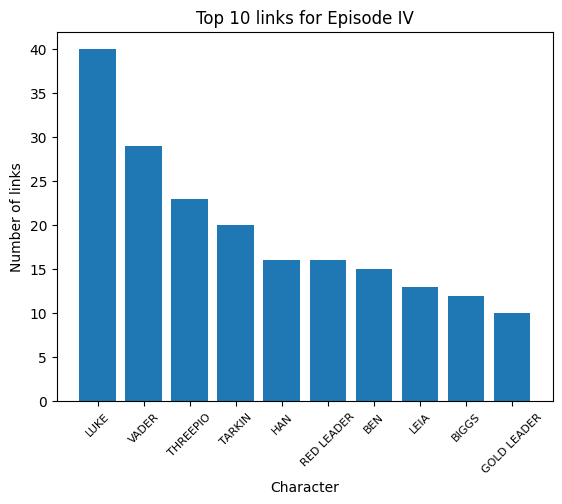

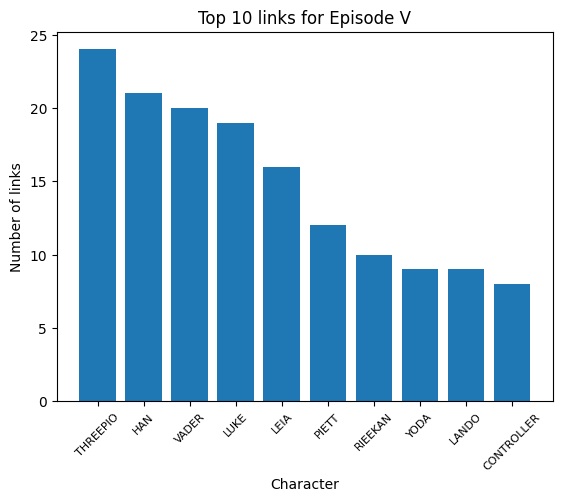

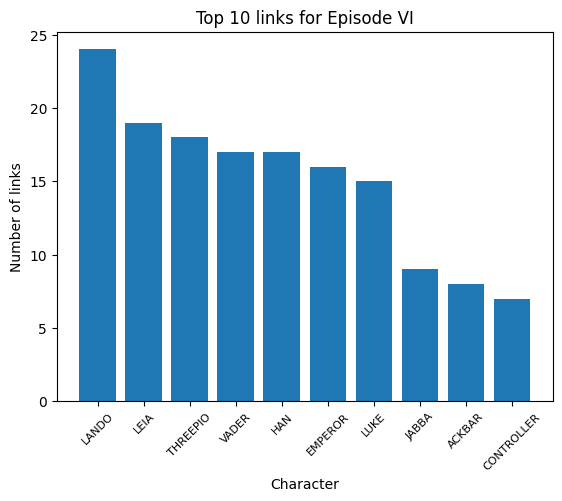

In [38]:
plotTopLinks(names, LinksTop10)

We will now try to make a temporal by looking a some of the most important characters and how their links to other characters develop over time. 

From the diagrams above we have identified the 5 main characters: Luke, C-3PO (Threepio), Han, Leia and Vader. We will do more work on these characters:

In [39]:
def number_of_links_over_time(character, links):
    character_name = character.upper()
    all_nodes = []
    all_links = []
    nodes_for_each_ep = []
    links_for_each_ep = []
    for links_for_ep in links:
        for link in links_for_ep:
            if link[0] == character_name:
                nodes_for_each_ep.append(link[1])
            if link[1] == character_name:
                nodes_for_each_ep.append(link[0])
            if character_name in link:
                links_for_each_ep.append(tuple(link))
        all_nodes.append(nodes_for_each_ep[:])
        all_links.append(links_for_each_ep[:])
    print("Nodes: ", [len(node) for node in all_nodes])
    print("Links: ", [len(link) for link in all_links])
    return all_nodes, all_links

def number_of_links_lst(all_nodes, all_links):
    return [len(node) for node in all_nodes], [len(link) for link in all_links]

In [40]:
import networkx as nx
import netwulf

def make_graph(nodes, links):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(links)
    return G

def draw_graphs(graphs):
    fig, axs = plt.subplots(1, len(graphs), figsize=(5*len(graphs), 5))
    for i, graph in enumerate(graphs):
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, with_labels=True, font_size = 5, ax=axs[i])
        #plt.title(f"Episode {i+4}")
        #plt.show()
        axs[i].set_title(f'Episode {i+1}')

We will start by analyzing Lukes social connections and the development of the social structure around in him first:

In [41]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("LUKE", links)

Nodes:  [43, 63, 78]
Links:  [43, 63, 78]


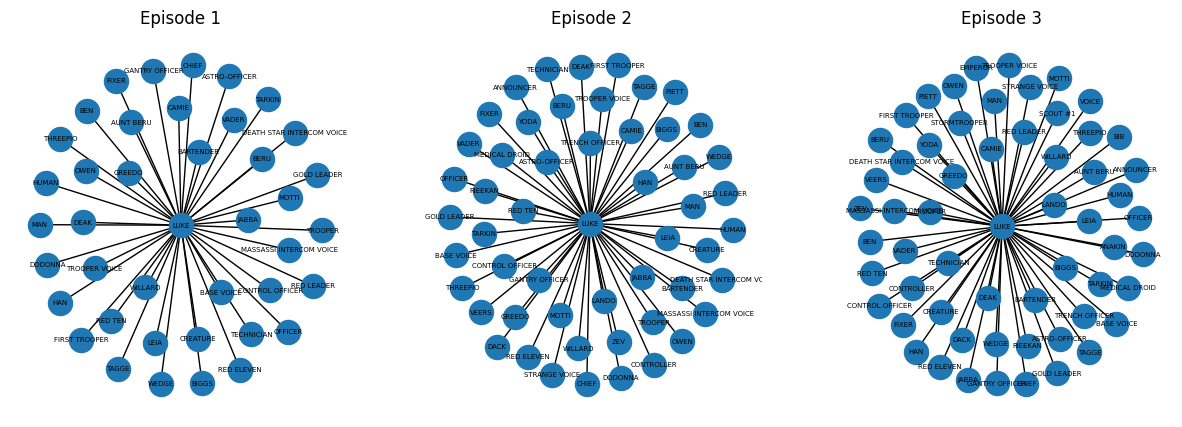

In [42]:
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
luke_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

----

We will now replicate this for the other main characters:

#### Threepio

Nodes:  [27, 56, 74]
Links:  [27, 56, 74]


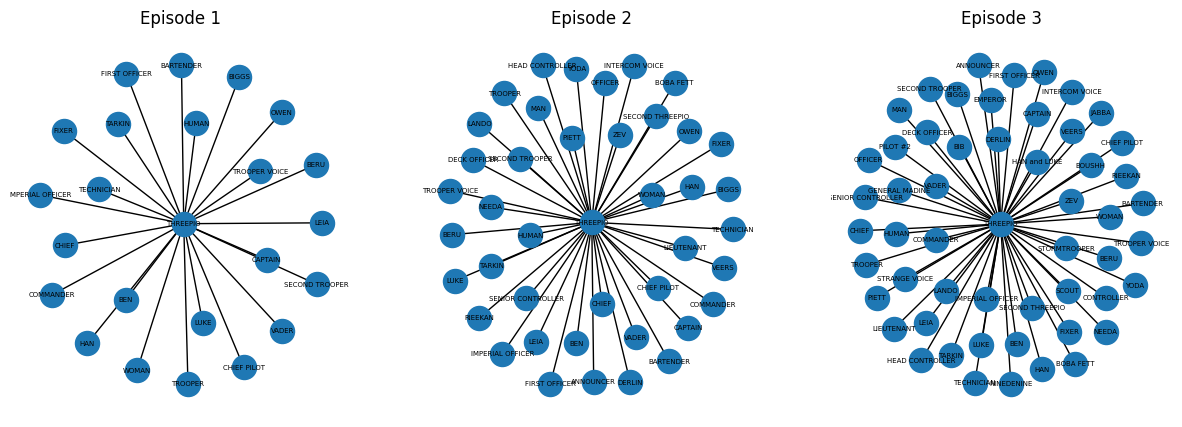

In [43]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("threepio", links)
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
threepio_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

### Vader

Nodes:  [33, 55, 73]
Links:  [33, 55, 73]


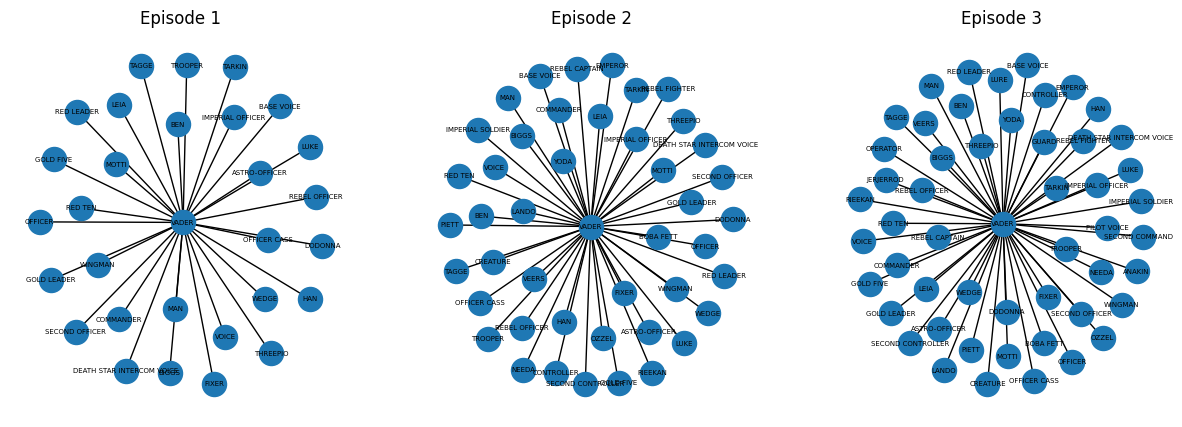

In [44]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("vader", links)
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
vader_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

### HAN

Nodes:  [16, 40, 57]
Links:  [16, 40, 57]


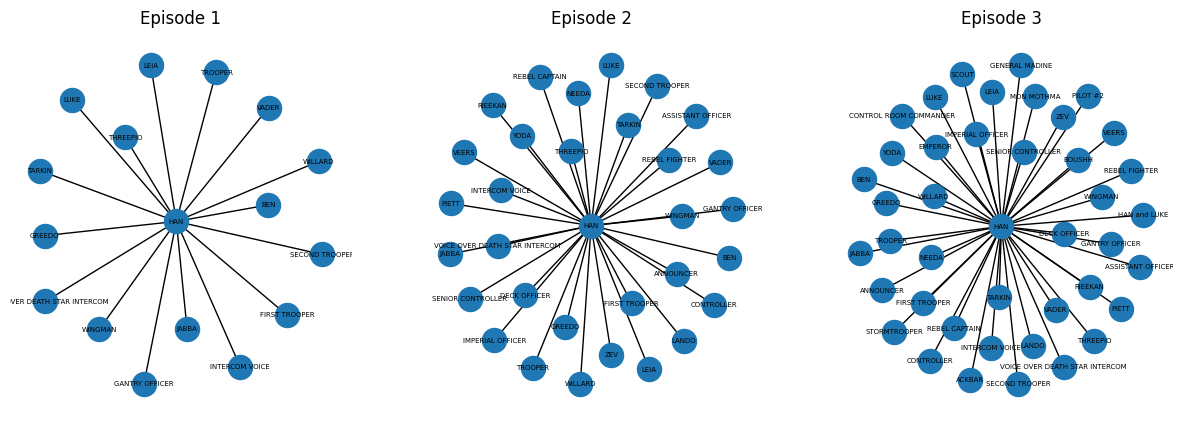

In [45]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("han", links)
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
han_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

### LEIA

Nodes:  [14, 32, 51]
Links:  [14, 32, 51]


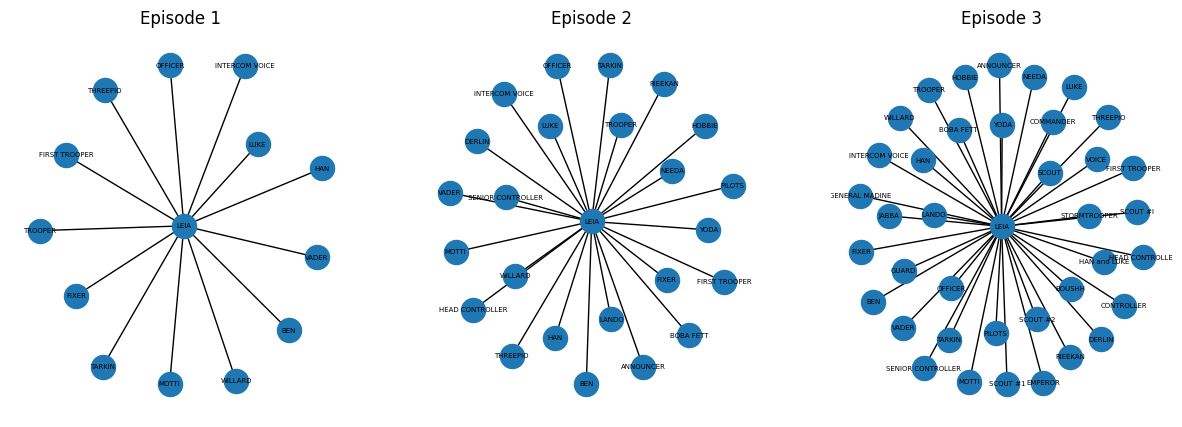

In [46]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("leia", links)
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
leia_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

We can see that all characters develop their relationsships and connections over time.

---

To get a better understanding of how many new connections each character makes, we can determine the procent growth relative to episode 4:

In [47]:
def procent_rise(args):
    nodes, links = args
    nodes_percentage = [round((node - nodes[0])/nodes[0]*100, 2) for node in nodes]
    links_percentage = [round((link - links[0])/links[0]*100, 2) for link in links]
    print("Rise in nodes: ", [str(per) + "%" for per in nodes_percentage])
    print("Rise in links: ", [str(per) + "%" for per in links_percentage], "\n")
    return nodes_percentage, links_percentage

names = ["Luke", "Threepio", "Vader", "Han", "Leia"]
lengths = [luke_len, threepio_len, vader_len, han_len, leia_len]

for name, length in zip(names, lengths):
    print(f"{name}")
    procent_rise(length)

Luke
Rise in nodes:  ['0.0%', '46.51%', '81.4%']
Rise in links:  ['0.0%', '46.51%', '81.4%'] 

Threepio
Rise in nodes:  ['0.0%', '107.41%', '174.07%']
Rise in links:  ['0.0%', '107.41%', '174.07%'] 

Vader
Rise in nodes:  ['0.0%', '66.67%', '121.21%']
Rise in links:  ['0.0%', '66.67%', '121.21%'] 

Han
Rise in nodes:  ['0.0%', '150.0%', '256.25%']
Rise in links:  ['0.0%', '150.0%', '256.25%'] 

Leia
Rise in nodes:  ['0.0%', '128.57%', '264.29%']
Rise in links:  ['0.0%', '128.57%', '264.29%'] 



Han and Leia seems to be the ones with the most growing connections. This could be due to two different theories:
- They are the more important and have more dialogues that the other main characters and thus making more connections
- There were simply just not present in the first movie thus making a extraordinary growth

We can first check the total number of links for all episode for each of the characters:

In [48]:
def character_links_all_episodes(name, nodes, links):
    nodes = [element for lst in nodes for element in lst]
    links = [element for lst in links for element in lst]
    number_of_links = {key: 0 for key in nodes}
    for i in range(len(links)):
        # to avoid duplicates
        if [links[i][1], links[i][0]] not in links[:i]:
            number_of_links[links[i][0]] += 1
            number_of_links[links[i][1]] += 1
    return number_of_links[name]

def character_dialogues_all_episode(name):
    return sum([len(df[df['character'] == name]) for df in cleaned_episodes])

names = ["Luke", "Threepio", "Vader", "Han", "Leia"]
for name in names:
    print(f"{name}: Total Links: {character_links_all_episodes(name.upper(), nodes, links)}, Total Dialogues: {character_dialogues_all_episode(name.upper())}")

Luke: Total Links: 72, Total Dialogues: 494
Threepio: Total Links: 61, Total Dialogues: 301
Vader: Total Links: 63, Total Dialogues: 140
Han: Total Links: 52, Total Dialogues: 459
Leia: Total Links: 47, Total Dialogues: 227


It seems that all characters end up having the (very close to) same number of connections at the end. 

We can see that they do not have the same amount of dialogues, which means some people interact more with each other than others (we can imagine Luke and Threepio have a pretty strong connection and a lot of dialogues together. 

This proves that the first hypothesis is wrong. Han and Leia does not significantly more dialogues with others that the other main characters have (although Han is at the top for sure!)

By looking and the graphs made before, we can see that both Han and Leia have a small amount of connections in the first movie. Based on the diagrams at the top of this section, we can also see that both Han and Leia have a significantly lower amount of dialogues in the first movie compared to the other characters.

This matches the story line and movie pretty well, as both of them are not as present in the first movie as they later (in movie 5 and 6), where they become much more of a main character.

----

## Word Frequency

In [49]:
dialogues = [ep["dialogue"].values for ep in cleaned_episodes]
dialogues[0]

array(["Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!",
       "We're doomed!",
       "There'll be no escape for the Princess this time.", ...,
       "We'll get to work on him right away.",
       "You must repair him!  Sir, if any of my circuits or gears will help, I'll gladly donate them.",
       "He'll be all right."], dtype=object)

In [118]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from string import punctuation
from collections import Counter, defaultdict
from statistics import mode
import numpy as np
import string

stopwords = stopwords.words('english')
punctuation = list(punctuation)
ps = PorterStemmer()

# Convert a piece of text into tokens
# With stemming, punctuation removal, stopword removal, and digit removal etc.
def get_tokens(text):
    tokens_raw_lower = (text.lower()).translate(str.maketrans('', '', '!"\'#$%&()*+,./:;<=>?@[\\]^_`{|}~')).split(" ")
    
    tokens = []
    for token in tokens_raw_lower:
        if token.isdigit(): # Remove digits
            continue
        elif token in punctuation or token in ["'s","'re","'ve","'ll",] or token in stopwords: # Remove punctuation and stopwords
            continue
        elif any(symbol in token for symbol in ["`","’",".","--"]):
            continue
        
        token = ps.stem(token)
        tokens.append(token)
    return tokens

Here we include the nltk browns news corpus to have something to compare the words from the movie dataset to. This did significantly improve the results, especially when we don't include the brown corpus in the final TF-IDF graphs.  
We also reuse/redefine the functions and variables we created to make the wordclouds TF-IDF for the Star Wars Databank dataset (with minor changes).

In [125]:
from nltk.corpus import brown
text_brown = " ".join(brown.words(categories="news"))
text_brown_tokens = get_tokens(text_brown)
def func():
    for i in range(0, len(text_brown_tokens), 10_500):
        yield text_brown_tokens[i:i + 10_500]

texts = [(" ".join(dialogue)).lower() for dialogue in dialogues]
documents = list(map(get_tokens, texts)) + list(func())
number_of_documents = len(documents)

# Tokenizing the entire corpus:
star_wars_vocab = (" ".join(texts).lower()).translate(str.maketrans('', '', '!"\'#$%&()*+,./:;<=>?@[\\]^_`{|}~')).split(" ")
# Making the dictionary of connections between stemmed words and the "original" words:
star_wars_vocab_dict = defaultdict(list)
for v in star_wars_vocab:
    star_wars_vocab_dict[ps.stem(v)].append(v)
# The function to "recreate" the tokens:
token_beautifier = lambda token: mode(sorted(star_wars_vocab_dict[token])) # The "beautified" token function.

# TF and IDF formulas:
IDF = lambda term_count: np.log10(number_of_documents / term_count)
TF = lambda term_count, N: (term_count / N) * 100

# Finding the IDF for the whole corpus:
corpus_total_tokens = sum([list(set(tokens)) for tokens in documents], [])
corpus_total_tokens_count = Counter(corpus_total_tokens)
IDF_dict = {word: IDF(count) for word, count in corpus_total_tokens_count.items()}

def get_TF_IDF_simple(tokens_lists):
    output_dict = []
    for token_list in tokens_lists:
        doc_counter = Counter(token_list)
        tf_idf = {token_beautifier(word): TF(count, len(token_list)) * IDF_dict[word] for word, count in doc_counter.items()}
        output_dict.append(dict(sorted(tf_idf.items(), key=lambda item: item[1], reverse=True)))
    return output_dict

C:\Users\alexa\AppData\Local\Temp\ipykernel_10836\3082969308.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(common_words, rotation=40, ha="right")


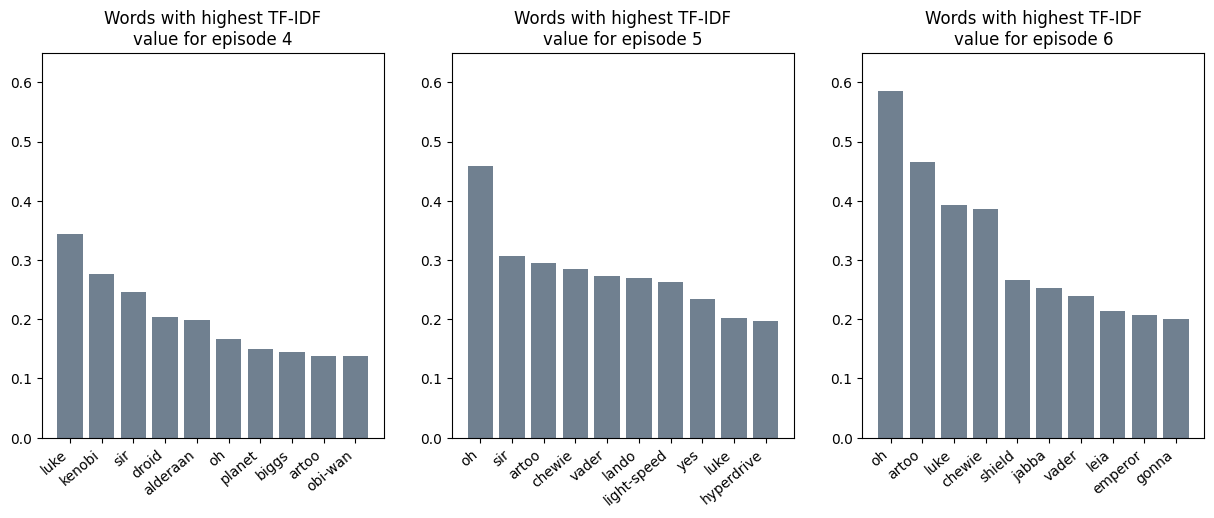

In [126]:
# Getting the TF-IDF for the episodes:
tokens_sw2 = list(map(get_tokens, texts))
dict1 = get_TF_IDF_simple(tokens_sw2)

# Plotting a bar plot of the TF-IDF values for each episode:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    common_words = list(dict1[i].keys())[:10]
    word_freq = list(dict1[i].values())[:10]

    axs[i].bar(common_words, word_freq, color="slategray")
    axs[i].set_title(f"Words with highest TF-IDF\nvalue for episode {i+4}")
    axs[i].set_xticklabels(common_words, rotation=40, ha="right")
    axs[i].set_ylim(0, 0.65)

C:\Users\alexa\AppData\Local\Temp\ipykernel_10836\2631574421.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(common_words, rotation=40, ha="right")


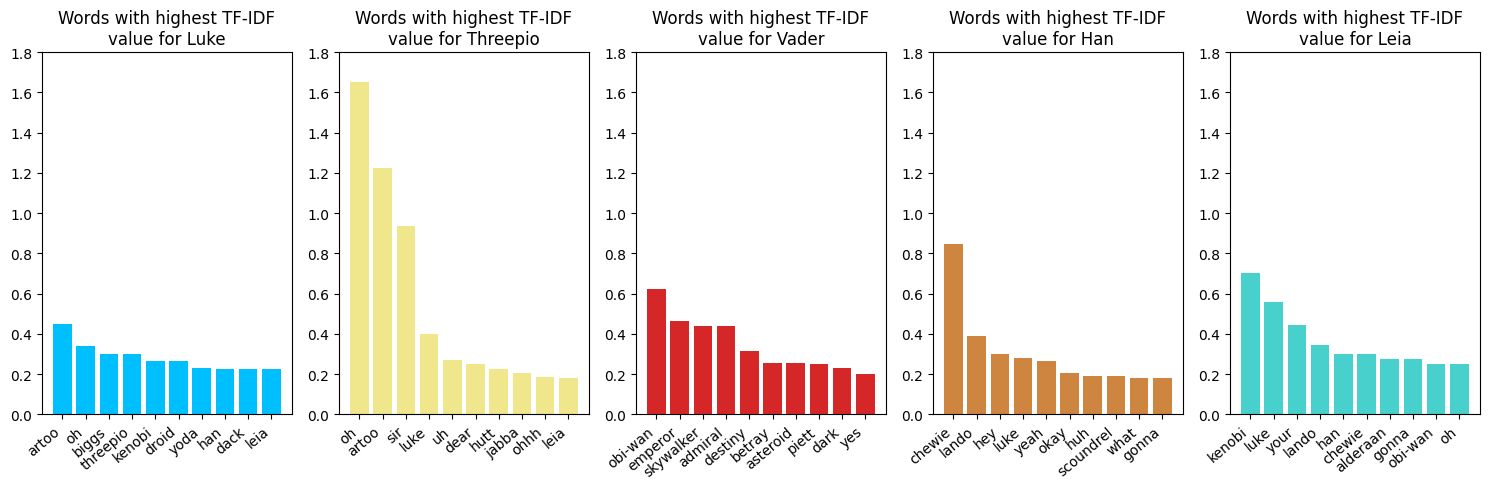

In [121]:
# We take the cleaned episodes and group them by character and add all their dialogues together:
clean_eps = pd.concat(cleaned_episodes, axis=0).groupby("character")["dialogue"].apply(lambda x: " ".join(x)).to_frame()
text_protags = clean_eps.loc[["LUKE", "THREEPIO", "VADER", "HAN", "LEIA"]]["dialogue"].to_list()

# We tokenize the dialogues and get TF-IDF:
tokens_protags = list(map(get_tokens, text_protags))
dict2 = get_TF_IDF_simple(tokens_protags)

# Plotting them similar to the last plot:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
colors = ["deepskyblue", "khaki", "tab:red", "peru", "mediumturquoise"]
for i in range(5):
    common_words = list(dict2[i].keys())[:10]
    word_freq = list(dict2[i].values())[:10]

    axs[i].bar(common_words, word_freq, color=colors[i])
    axs[i].set_title(f"Words with highest TF-IDF\nvalue for {names[i]}")
    axs[i].set_xticklabels(common_words, rotation=40, ha="right")
    fig.tight_layout()
    axs[i].set_ylim(0, 1.8)

----

### Discussion:


#### We will now try to answer some of the question that we intended to answer from the introduction:

----

##### What are the most dominant groups? Are the characters mainly connected by social, political or other types of relationsships?

The dominant groups are the appearances. This means that the likelihood of two nodes being connected is highly determined by the material in which two characters appear. This makes a lot of sense as screen time together probably means interaction. The source from which we got the data is also inherently biased towards this type of interaction, as the nature of the movies means that sharing a scene correlates with having a meaningful relation.

---
##### What are the words from each group dominated by? Are there any significant differences in the words used in the different groups?

We discovered that it was indeed very easy to distinguish most of the big factions/groups by each other. With some groups mainly being dominated by military and hierarchical terms (the Empire), while others were dominated by more social and political terms (the Republic). The Jedi Order being very self-contained with terms related to their ideology etc. And the Rebels and the Resistance being very similar in their use of terms, with the Resistance including a lot of new names and words, because it is further ahead in time.

---- 
##### We wanted to find out which characters where the most dominant in each movie. Would that match our expectation?

It did! It seems that all characters end up having the (very close to) same number of connections at the end. We can see that they do not have the same amount of dialogues, which means some people interact more with each other than others. The table in the page "Movie Scripts" proves the analysis made for each of the main characters. Luke is having many conversations with many different people. C-3PO has a bunch of conversation, but that with as many different people. Vader has the least amount of dialogues, but second most relationsships. Leia and Han have least amount of relationsships, but han with double the amount of dialogues. This matches the storyline in the movies.

----
##### Could we predict the story of the movie by using TF-IDF?

It wasn't exactly possible to predict the future story using TF-IDF, but it was possible to predict which episode was which based only on the TF-IDF plots.

----

##### What where the most used words by each main character? What are their semantics?

Interestingly enough the words that often dominated the TF-IDF scores were exclamations like "Oh", "Ohh" and "Uh" for characters like C-3PO, and some for Luke Skywalker as well. And a laidback character like Han Solo had a lot of "Yeah", "Ok" and "Hey" in his vocabulary. But the most used words were often names of other characters, which makes sense, because the characters often talk about each other.

---

- What went well?
- What is still missing? What could be improved? Why?

We do feel like, we got some information out of this project. We think a lot of things could have been done better. Most of our time where spent of the graphs and TF-IDF. The graphs did not pay off. It was very close to impossible to see anything on them, although we did get a tiny bit of information.

The TF-IDF went a lot better, and we used in both with the characters and movie scripts. We think that is the strongest part of this project.

If we had more time, we would have:
1. Gathered more data: We think it is possible to gather more data about Star Wars and analyze those.
2. Do more work on the graphs to get better insight into the groups and social structures within. Unfortunately we were not really able to answer this question: "Are the characters mainly connected by social, political or other types of relationsships?", which we really would have loved to be able to.

We hope that the website gives whoever visits it some insight into the social structures in the Star Wars Universe. We did think that we personally did get some more knowledge about how the different characters interact and the words they use.

---